In [1]:
"""
EasyLM Demo — CarDekho Dataset
Shows:
- Data loading and preprocessing
- Fit multiple models
- R-style summaries
- Model comparison
- Visualizations
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, os.path.abspath('..'))
from EasyLM import LinearModel, ModelComparator, PlotHelper


# ------------------------- STEP 1 -------------------------
def load_data():
    df = pd.read_csv('car details.csv')
    print(f"\nLoaded dataset: {df.shape}")
    return df




Loaded dataset: (4340, 8)
Cleaned dataset: (4340, 15)

Feature sets prepared.
Model 1: Simple (KM) → R²=0.0370 AIC=115008.14 BIC=115020.89
Model 2: KM + Age → R²=0.1717 AIC=114355.82 BIC=114374.95
Model 3: + Fuel → R²=0.2401 AIC=113990.25 BIC=114034.88
Model 4: Full Model → R²=0.2639 AIC=113863.93 BIC=113946.81

--- Model 1: Simple (KM) ---

Call: EasyLM LinearModel

Observations: 4340
Parameters: 2
Degrees of Freedom (resid): 4338

Coefficients:
         Coef.  Std.Err.  t value  Pr(>|t|)
0  504127.3118 8619.1400  58.4893    0.0000
1 -111235.5268 8619.1400 -12.9056    0.0000

Residual variance (sigma^2): 322416752701.7704
R-squared: 0.0370
AIC: 115008.1404
BIC: 115020.8917

--- Model 2: KM + Age ---

Call: EasyLM LinearModel

Observations: 4340
Parameters: 3
Degrees of Freedom (resid): 4337

Coefficients:
         Coef.  Std.Err.  t value  Pr(>|t|)
0  504127.3118 7994.2180  63.0615    0.0000
1  -13039.5210 8807.4216  -1.4805    0.1388
2 -233973.7416 8807.4216 -26.5655    0.0000

Resi

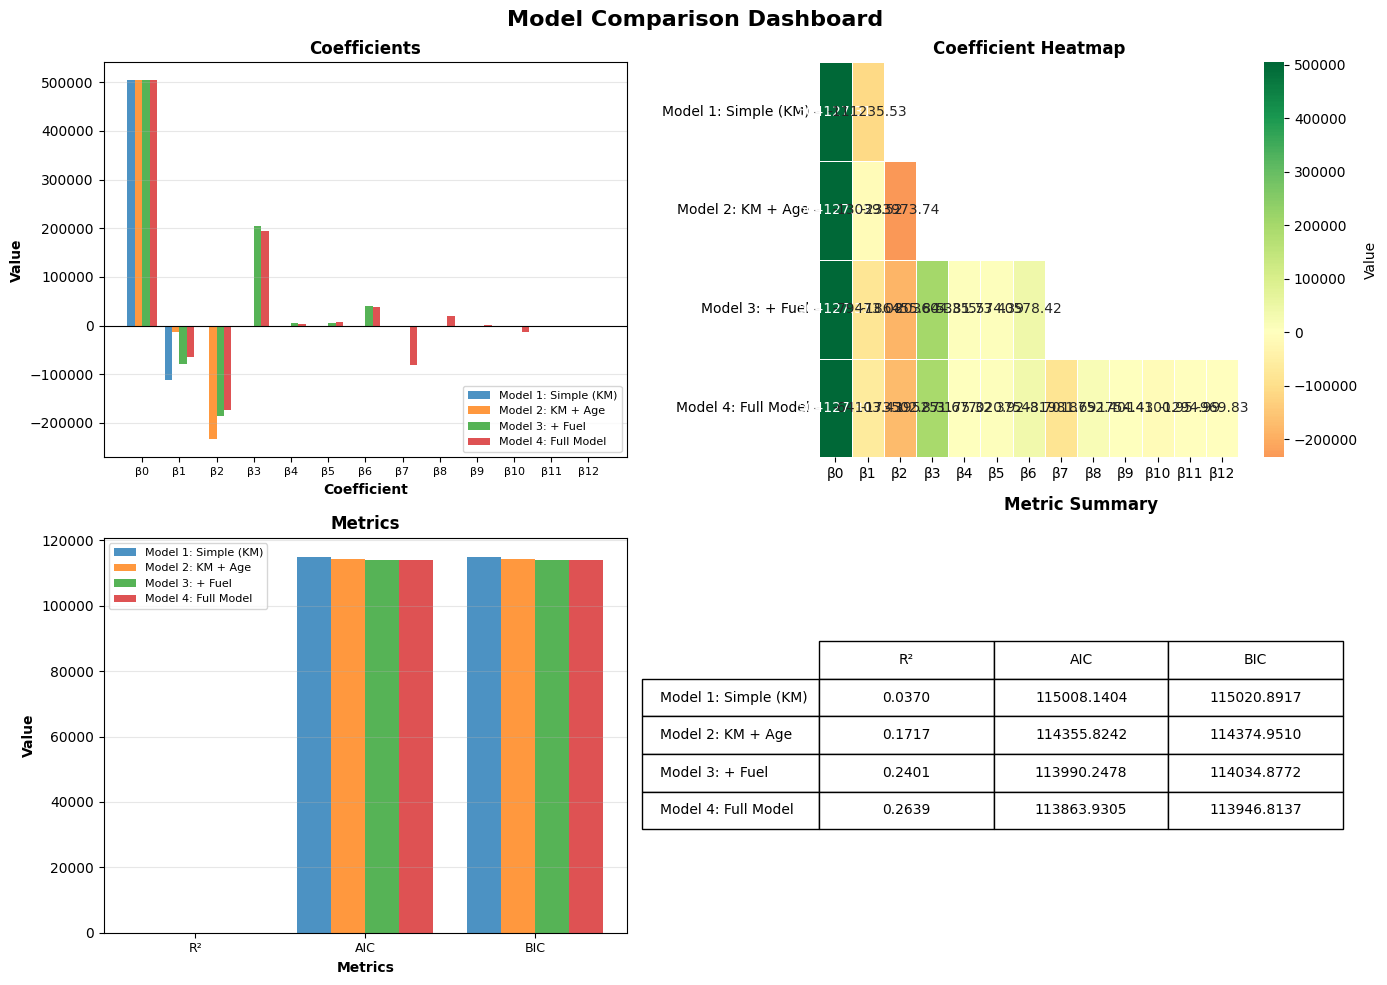


=== Final Summary ===
Model 1: Simple (KM): R²=0.0370, AIC=115008.1, BIC=115020.9
Model 2: KM + Age: R²=0.1717, AIC=114355.8, BIC=114375.0
Model 3: + Fuel: R²=0.2401, AIC=113990.2, BIC=114034.9
Model 4: Full Model: R²=0.2639, AIC=113863.9, BIC=113946.8

Recommended Model → Model 4: Full Model
Explains 26.4% of variance.

Done.


In [7]:

# ------------------------- STEP 2 -------------------------
def preprocess_data(df):
    df = df.dropna().copy()

    if 'year' in df:
        df['age'] = 2024 - df['year']

    if df['km_driven'].dtype == 'object':
        df['km_driven'] = (df['km_driven']
            .str.replace(' km', '', regex=False)
            .str.replace(',', '', regex=False)
            .astype(float))

    if df['selling_price'].dtype == 'object':
        df['selling_price'] = (df['selling_price']
            .str.replace('₹', '', regex=False)
            .str.replace(',', '', regex=False)
            .astype(float))

    categorical = ['fuel', 'seller_type', 'transmission', 'owner']
    for col in categorical:
        if col in df:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, drop_first=True)], axis=1)
            df = df.drop(col, axis=1)

    df = df.drop(df.select_dtypes(include=['object']).columns, axis=1)
    print(f"Cleaned dataset: {df.shape}")
    return df


# ------------------------- STEP 3 -------------------------
def prepare_features(df):
    y = df['selling_price'].values

    fuel_cols = [c for c in df if c.startswith('fuel_')]
    seller_cols = [c for c in df if c.startswith('seller_')]
    trans_cols = [c for c in df if c.startswith('trans_')]
    owner_cols = [c for c in df if c.startswith('owner_')]

    all_cat = fuel_cols + seller_cols + trans_cols + owner_cols

    feature_sets = {
        'model1': ['km_driven'],
        'model2': ['km_driven', 'age'],
        'model3': ['km_driven', 'age'] + fuel_cols,
        'model4': ['km_driven', 'age'] + all_cat
    }

    print("\nFeature sets prepared.")
    return y, feature_sets, df


# ------------------------- STEP 4 -------------------------
def fit_all_models(df, y, feature_sets):
    models = []
    scaler = StandardScaler()

    names = [
        "Model 1: Simple (KM)",
        "Model 2: KM + Age",
        "Model 3: + Fuel",
        "Model 4: Full Model"
    ]

    for (key, name) in zip(feature_sets, names):
        X = df[feature_sets[key]].values
        Xs = scaler.fit_transform(X)

        m = LinearModel(add_intercept=True)
        m.fit(Xs, y)
        m.name = name

        print(f"{name} → R²={m.r_squared():.4f} AIC={m.aic():.2f} BIC={m.bic():.2f}")
        models.append(m)

    return models


# ------------------------- STEP 5 -------------------------
def show_individual_summaries(models):
    for m in models:
        print(f"\n--- {m.name} ---\n")
        print(m.summary())


# ------------------------- STEP 6 -------------------------
def compare_metrics(models):
    cmp = ModelComparator(models)
    df = cmp.compare()

    print("\nModel Comparison:")
    print(df.to_string())

    best_r2 = df['r_squared'].idxmax()
    best_aic = df['aic'].idxmin()
    best_bic = df['bic'].idxmin()

    print("\nBest Models:")
    print("R² :", best_r2)
    print("AIC:", best_aic)
    print("BIC:", best_bic)

    best = {m.name: m for m in models}[best_bic]
    return df, cmp, best


# ------------------------- STEP 7 -------------------------
def compare_coefficients(comparator):
    print("\nCoefficient Table:")
    print(comparator.coef_table().to_string())


# ------------------------- STEP 8 -------------------------
'''def visualize_coefficients(models):
    PlotHelper.coef_plot(*models, style='bar')
    plt.show()
    #PlotHelper.coef_plot(*models, style='heatmap')
    #plt.show()
    #PlotHelper.coef_ci_plot(*models)
    #plt.show()


# ------------------------- STEP 9 -------------------------
def visualize_metrics(models):
    PlotHelper.metric_plot(*models, style='bar')
    plt.show()
    #PlotHelper.metric_plot(*models, style='radar')
    #plt.show()
    PlotHelper.metric_plot(*models, style='heatmap')
    plt.show()'''


# ------------------------- STEP 10 -------------------------
def show_dashboard(models):
    PlotHelper.compare(*models)
    plt.show()


# ------------------------- STEP 11 -------------------------
def final_recommendations(models, cmp_df, best):
    print("\n=== Final Summary ===")
    for m in models:
        print(f"{m.name}: R²={m.r_squared():.4f}, AIC={m.aic():.1f}, BIC={m.bic():.1f}")

    print(f"\nRecommended Model → {best.name}")
    print(f"Explains {best.r_squared()*100:.1f}% of variance.")


# ------------------------- MAIN -------------------------
if __name__ == "__main__":
    df_raw = load_data()
    df_clean = preprocess_data(df_raw)
    y, feature_sets, df_clean = prepare_features(df_clean)

    models = fit_all_models(df_clean, y, feature_sets)
    show_individual_summaries(models)

    cmp_df, cmp, best = compare_metrics(models)
    compare_coefficients(cmp)

    #visualize_coefficients(models)
    #visualize_metrics(models)
    show_dashboard(models)

    final_recommendations(models, cmp_df, best)

    print("\nDone.")
